In [1]:
!pip install scikit-survival
!pip install scikit-learn
!pip install pycox
!pip install captum

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import sklearn.model_selection as model_selection

import torch
import torchtuples

import sksurv.datasets as datasets
import sksurv.linear_model as linear_model
import sksurv.ensemble as ensemble
import sksurv.functions as functions

import pycox
from pycox.datasets import metabric
import pycox.evaluation as evaluation

import captum.attr as attr
import survshap

import matplotlib.pyplot as plt

/home/maciej/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DeepHitSingleWrapper:
    def __init__(self, net, optim):
        self.net = net
        self.optim = optim
        
    def fit(self, train_data, train_target, val_data, val_target, epochs=10):
        cuts = self.net.net[-1].out_features
        lt = pycox.models.DeepHitSingle.label_transform(cuts)
        
        train_data = train_data.values 
        train_target = lt.fit_transform(train_target["duration"], train_target["event"])
        
        val_data = val_data.values
        val_target = lt.transform(val_target["duration"], val_target["event"])
        
        self.model = pycox.models.DeepHitSingle(self.net, self.optim, device='cpu', duration_index=lt.cuts)
        self.model.fit(train_data, train_target, epochs=epochs, val_data=(val_data, val_target))
        
        self.event_times_ = lt.cuts
        
    def predict_surv_df(self, data):
        return self.model.predict_surv_df(data.values)
        
    def score(self, data, target):
        surv_df = self.predict_surv_df(data)
        eval_surv = evaluation.EvalSurv(surv_df, target["duration"], target["event"])
        
        return eval_surv.concordance_td()
    
    def predict_survival_function(self, data):
        surv_df = self.predict_surv_df(data)
        ret = [functions.StepFunction(surv_df.index.values, values) for values in surv_df.T.values]
        
        return np.array(ret)

In [4]:
class Wrapper:
    def __init__(self, model, data, explainer):
        self.model = model
        self.baseline = torch.zeros(data.values.shape)
        self.explainer = explainer(self.model.net)
        
    def __call__(self, observation):
        data = torch.tensor(observation.values)

        attributions = []
        for i in range(len(self.model.event_times_)):
            attribution = self.explainer.attribute(data, self.baseline, i).detach().numpy()
            attributions.append(attribution)
        attributions = np.stack(attributions, axis=2)

        step_functions = {}
        for i, column in enumerate(observation.columns):
            step_functions[column] = [
                functions.StepFunction(self.model.event_times_, np.cumsum(attributions[j, i])) \
                for j in range(len(observation))
            ]
        
        return pd.DataFrame(step_functions)

In [5]:
class DeepLiftShapWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftShapWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.randn(data.values.shape) * 0.001
        self.explainer = attr.DeepLiftShap(self.model.net)

In [6]:
class DeepLiftWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftWrapper, self).__init__(model, data, attr.DeepLift)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.DeepLift(self.model.net)

In [7]:
class IntegratedGradientsWrapper(Wrapper):
    def __init__(self, model, data):
        super(IntegratedGradientsWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.IntegratedGradients(self.model.net)

In [8]:
class SurvShapWrapper:
    def __init__(self, model, data, target):
        self.model = model
        self.explainer = survshap.SurvivalModelExplainer(self.model, data, target)

    def __call__(self, observation):     
        surv_shap = survshap.PredictSurvSHAP()
        surv_shap.fit(self.explainer, observation, self.model.event_times_)
        result = surv_shap.result
        
        step_functions = {}
        for name, group in result.groupby(by="variable_name"):            
            step_functions[name] = [
                functions.StepFunction(self.model.event_times_, attributions)
                for attributions in group.iloc[:, 5:].values
            ]
            
        return pd.DataFrame(step_functions)

# Experiments

In [9]:
df = metabric.read_df()
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
2,5.920251,6.776564,12.431715,5.873857,0.0,1.0,0.0,1.0,48.439999,140.233337,0
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
...,...,...,...,...,...,...,...,...,...,...,...
1899,5.946987,5.370492,12.345780,5.741395,1.0,1.0,0.0,1.0,76.839996,87.233330,1
1900,5.339228,5.408853,12.176101,5.693043,1.0,1.0,0.0,1.0,63.090000,157.533340,0
1901,5.901610,5.272237,14.200950,6.139390,0.0,0.0,0.0,1.0,57.770000,37.866665,1
1902,6.818109,5.372744,11.652624,6.077852,1.0,0.0,0.0,1.0,58.889999,198.433334,0


In [10]:
data, target = datasets.get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, target)

In [11]:
random_survival_forest = ensemble.RandomSurvivalForest()
random_survival_forest.fit(train_data, train_target)

print(f"Train score = {random_survival_forest.score(train_data, train_target)}")
print(f"Test score = {random_survival_forest.score(test_data, test_target)}")

Train score = 0.8897375592533447
Test score = 0.6568532754674041


In [12]:
CoxPH_survival_analysis = linear_model.CoxPHSurvivalAnalysis()
CoxPH_survival_analysis.fit(train_data, train_target)

print(f"Train score = {CoxPH_survival_analysis.score(train_data, train_target)}")
print(f"Test score = {CoxPH_survival_analysis.score(test_data, test_target)}")

Train score = 0.6408131705906952
Test score = 0.6297286211413525


In [13]:
net = torchtuples.practical.MLPVanilla(train_data.shape[1], [32, 32], 100)
optim = torch.optim.Adam(net.parameters(), lr=1e-2)

deep_hit_single = DeepHitSingleWrapper(net, optim)
deep_hit_single.fit(train_data, train_target, test_data, test_target, epochs=20)
                           
print(f"Train score = {deep_hit_single.score(train_data, train_target)}")
print(f"Test score = {deep_hit_single.score(test_data, test_target)}")

0:	[1s / 1s],		train_loss: 0.9036,	val_loss: 0.9534
1:	[0s / 1s],		train_loss: 0.8534,	val_loss: 0.8929
2:	[0s / 1s],		train_loss: 0.8306,	val_loss: 0.8328
3:	[0s / 2s],		train_loss: 0.8185,	val_loss: 0.8271
4:	[0s / 2s],		train_loss: 0.8092,	val_loss: 0.8176
5:	[0s / 2s],		train_loss: 0.8047,	val_loss: 0.8142
6:	[0s / 2s],		train_loss: 0.7954,	val_loss: 0.8260
7:	[0s / 2s],		train_loss: 0.8005,	val_loss: 0.8158
8:	[0s / 2s],		train_loss: 0.7850,	val_loss: 0.8191
9:	[0s / 2s],		train_loss: 0.7738,	val_loss: 0.8171
10:	[0s / 2s],		train_loss: 0.7705,	val_loss: 0.8175
11:	[0s / 2s],		train_loss: 0.7620,	val_loss: 0.8312
12:	[0s / 2s],		train_loss: 0.7601,	val_loss: 0.8309
13:	[0s / 3s],		train_loss: 0.7550,	val_loss: 0.8396
14:	[0s / 3s],		train_loss: 0.7466,	val_loss: 0.8456
15:	[0s / 3s],		train_loss: 0.7400,	val_loss: 0.9021
16:	[0s / 3s],		train_loss: 0.7388,	val_loss: 0.8985
17:	[0s / 3s],		train_loss: 0.7306,	val_loss: 0.8494
18:	[0s / 3s],		train_loss: 0.7275,	val_loss: 0.8985
19:

/home/maciej/.local/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Train score = 0.6920519162751153
Test score = 0.6654101027736995


/home/maciej/.local/lib/python3.10/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


In [14]:
def plot(results):
    Xs = [result.x for result in results]
    Ys = [result.y for result in results]
    labels = list(results.index)

    plt.plot(np.array(Xs).T, np.array(Ys).T, label=labels)
    plt.legend(bbox_to_anchor=(1, 1))

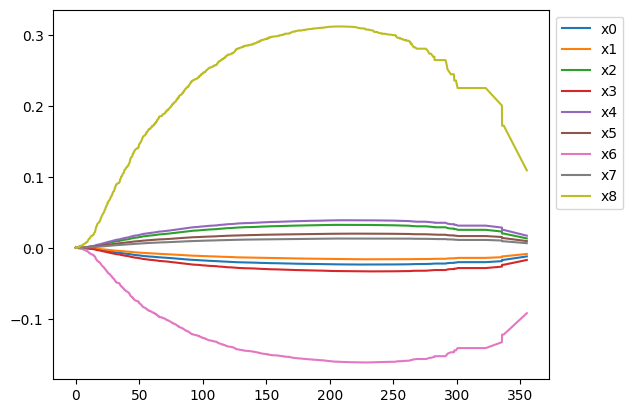

In [15]:
surv_shap_wrapper = SurvShapWrapper(CoxPH_survival_analysis, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

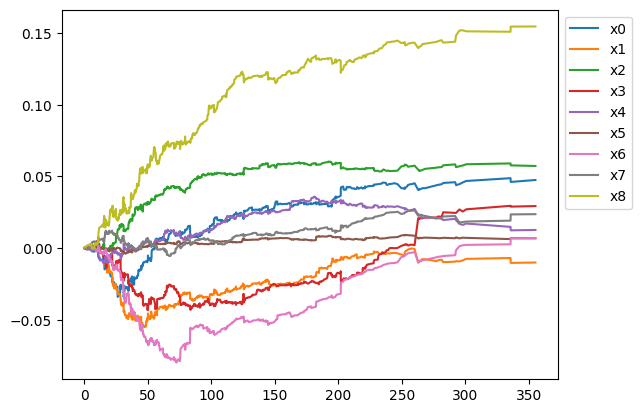

In [16]:
surv_shap_wrapper = SurvShapWrapper(random_survival_forest, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

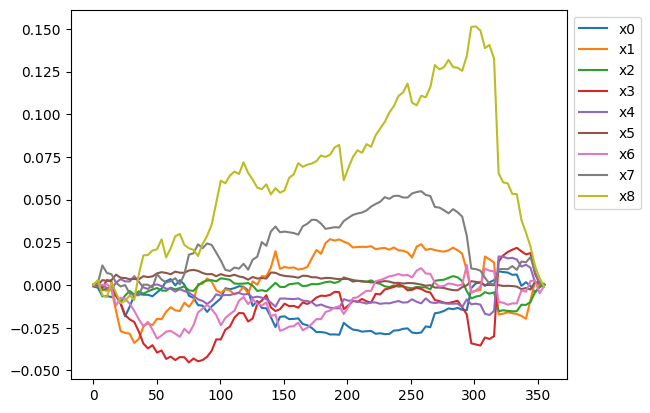

In [17]:
surv_shap_wrapper = SurvShapWrapper(deep_hit_single, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

/home/maciej/.local/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


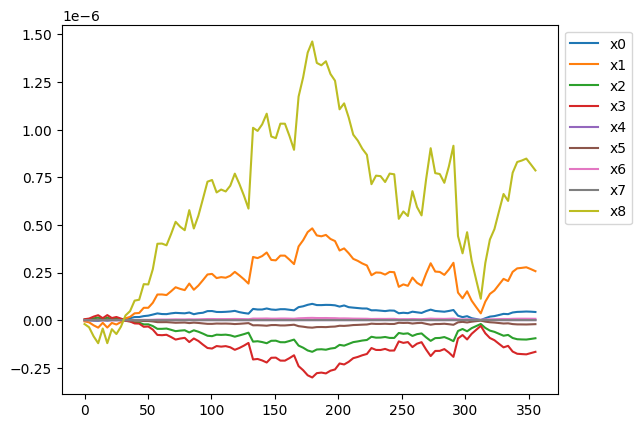

In [18]:
deep_lift_shap_wrapper = DeepLiftShapWrapper(deep_hit_single, test_data)
deep_lift_shap_results = deep_lift_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(deep_lift_shap_results)

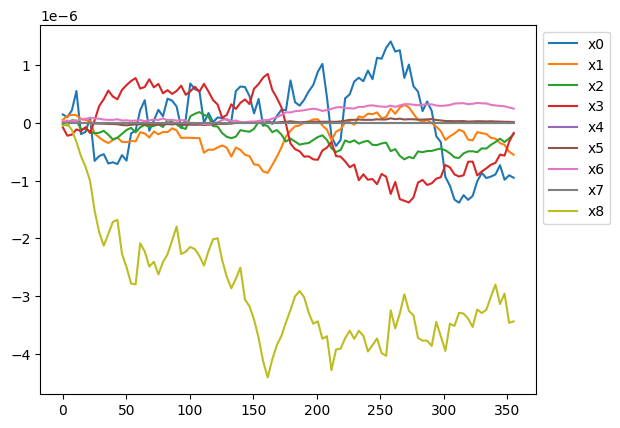

In [19]:
integrated_gradient_wrapper = IntegratedGradientsWrapper(deep_hit_single, test_data)
integrated_gradient_results = integrated_gradient_wrapper(test_data.iloc[[0]]).iloc[0]

plot(integrated_gradient_results)